In [193]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch
from sklearn.preprocessing import RobustScaler, QuantileTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt

In [194]:
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  0


In [195]:
# Load the data
csv_file = '/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/RND2/1_break_1/Data/cleaned_faifa_v2.csv'
df = pd.read_csv(csv_file)
df

,date_time,Temperature,Conductivity,TDS,Salinity,DO,Sensor_Depth,pH,Chlorophyll,Turbid
0,2016-10-28 14:00:00,31.355000,271.500000,177356.666667,0.128333,3189.930000,0.0,6.993333,0.0,59.826667
1,2016-10-28 15:00:00,31.413333,257.000000,167906.666667,0.120000,3098.725000,0.0,7.001667,0.0,51.596667
2,2016-10-28 16:00:00,31.488333,264.833333,172960.000000,0.125000,2987.713333,0.0,7.015000,0.0,52.148333
3,2016-10-28 17:00:00,31.346667,267.666667,174698.333333,0.123333,3177.026667,0.0,7.000000,0.0,57.010000
4,2016-10-28 18:00:00,31.318000,265.400000,173496.000000,0.124000,3132.854000,0.0,7.006000,0.0,55.990000
...,...,...,...,...,...,...,...,...,...,...
60455,2024-07-25 18:00:00,30.680000,503.333333,328.833333,0.240000,0.000000,0.0,0.000000,0.0,0.000000
60456,2024-07-25 19:00:00,30.686667,481.833333,314.666667,0.231667,0.000000,0.0,0.000000,0.0,0.000000
60457,2024-07-25 20:00:00,30.693417,537.333333,350.833333,0.259005,0.000000,0.0,0.000000,0.0,0.000000
60458,2024-07-25 21:00:00,30.688333,1039.833333,678.833333,0.513333,0.000000,0.0,0.000000,0.0,0.000000


In [196]:
df = df.loc[:, ['date_time', 'Salinity']]

In [197]:
# Convert date_time to datetime format and set as the index
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df['date_time_copy'] = df['date_time']
df.set_index('date_time', inplace=True)
df

,Salinity,date_time_copy
date_time,,
2016-10-28 14:00:00,0.128333,2016-10-28 14:00:00
2016-10-28 15:00:00,0.120000,2016-10-28 15:00:00
2016-10-28 16:00:00,0.125000,2016-10-28 16:00:00
2016-10-28 17:00:00,0.123333,2016-10-28 17:00:00
2016-10-28 18:00:00,0.124000,2016-10-28 18:00:00
...,...,...
2024-07-25 18:00:00,0.240000,2024-07-25 18:00:00
2024-07-25 19:00:00,0.231667,2024-07-25 19:00:00
2024-07-25 20:00:00,0.259005,2024-07-25 20:00:00


In [198]:
df_og = df.copy()

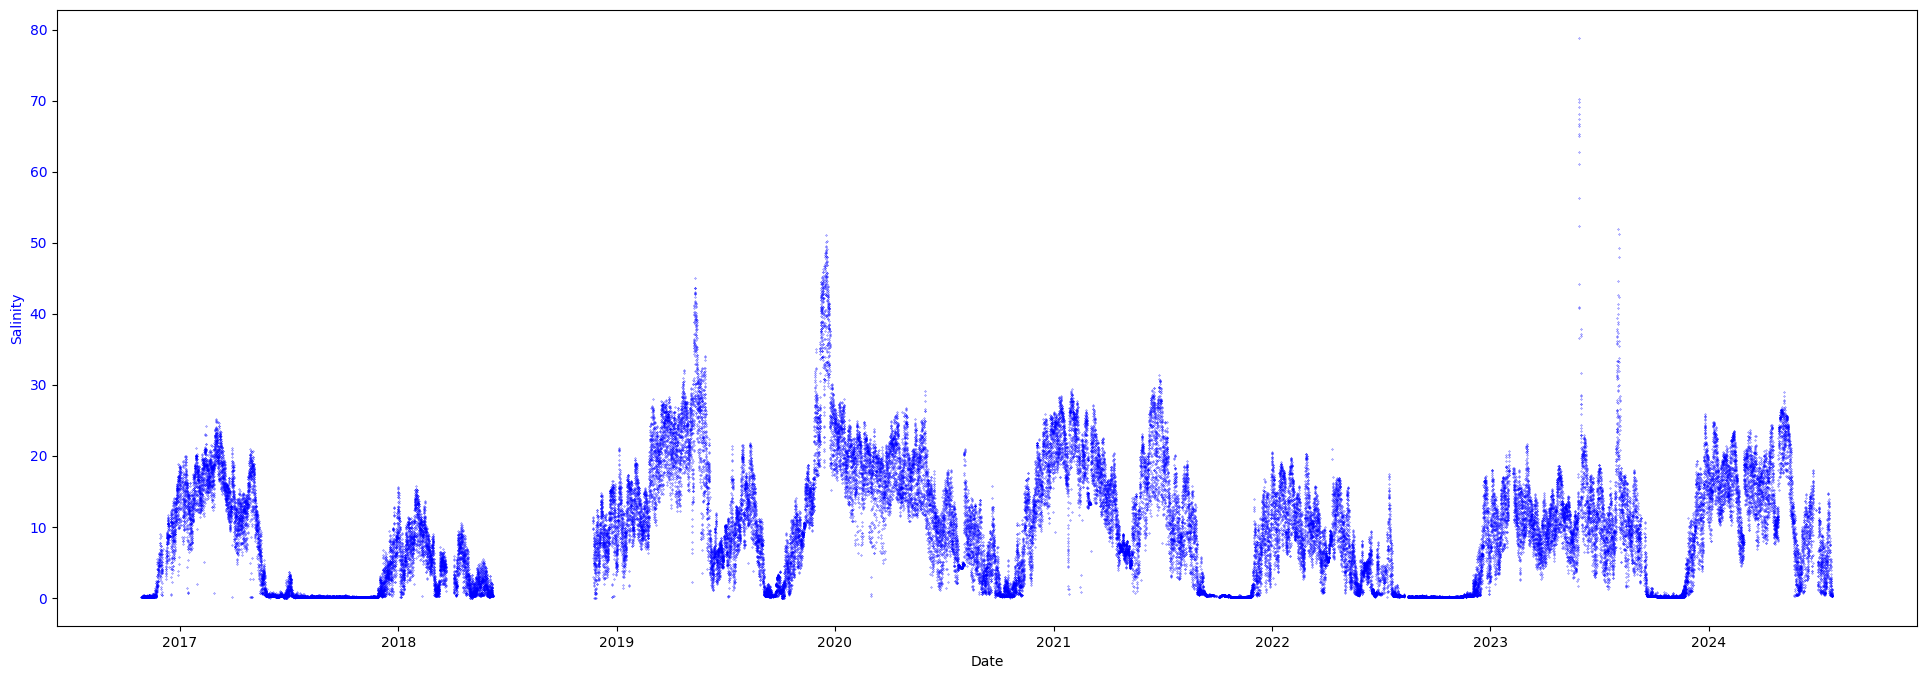

In [199]:
fig1, ax1 = plt.subplots(figsize=(24, 8))
ax1.plot(df_og.index, df_og['Salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='b')
ax1.tick_params(axis='y', labelcolor='b')



In [200]:
df = df.loc['2019-01-01':,:]
df = df[df['Salinity'] < 60]

date_time_copy = df.pop('date_time_copy')
timestamp_s = date_time_copy.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df

,Salinity,Day sin,Day cos,Year sin,Year cos
date_time,,,,,
2019-01-01 00:00:00,5.013333,-5.030095e-12,1.000000e+00,0.002021,0.999998
2019-01-01 01:00:00,4.792500,2.588190e-01,9.659258e-01,0.002738,0.999996
2019-01-01 02:00:00,4.698333,5.000000e-01,8.660254e-01,0.003455,0.999994
2019-01-01 03:00:00,4.563333,7.071068e-01,7.071068e-01,0.004172,0.999991
2019-01-01 04:00:00,4.558000,8.660254e-01,5.000000e-01,0.004888,0.999988
...,...,...,...,...,...
2024-07-25 18:00:00,0.240000,-1.000000e+00,-9.238784e-12,-0.401768,-0.915741
2024-07-25 19:00:00,0.231667,-9.659258e-01,2.588190e-01,-0.402425,-0.915453
2024-07-25 20:00:00,0.259005,-8.660254e-01,5.000000e-01,-0.403081,-0.915164


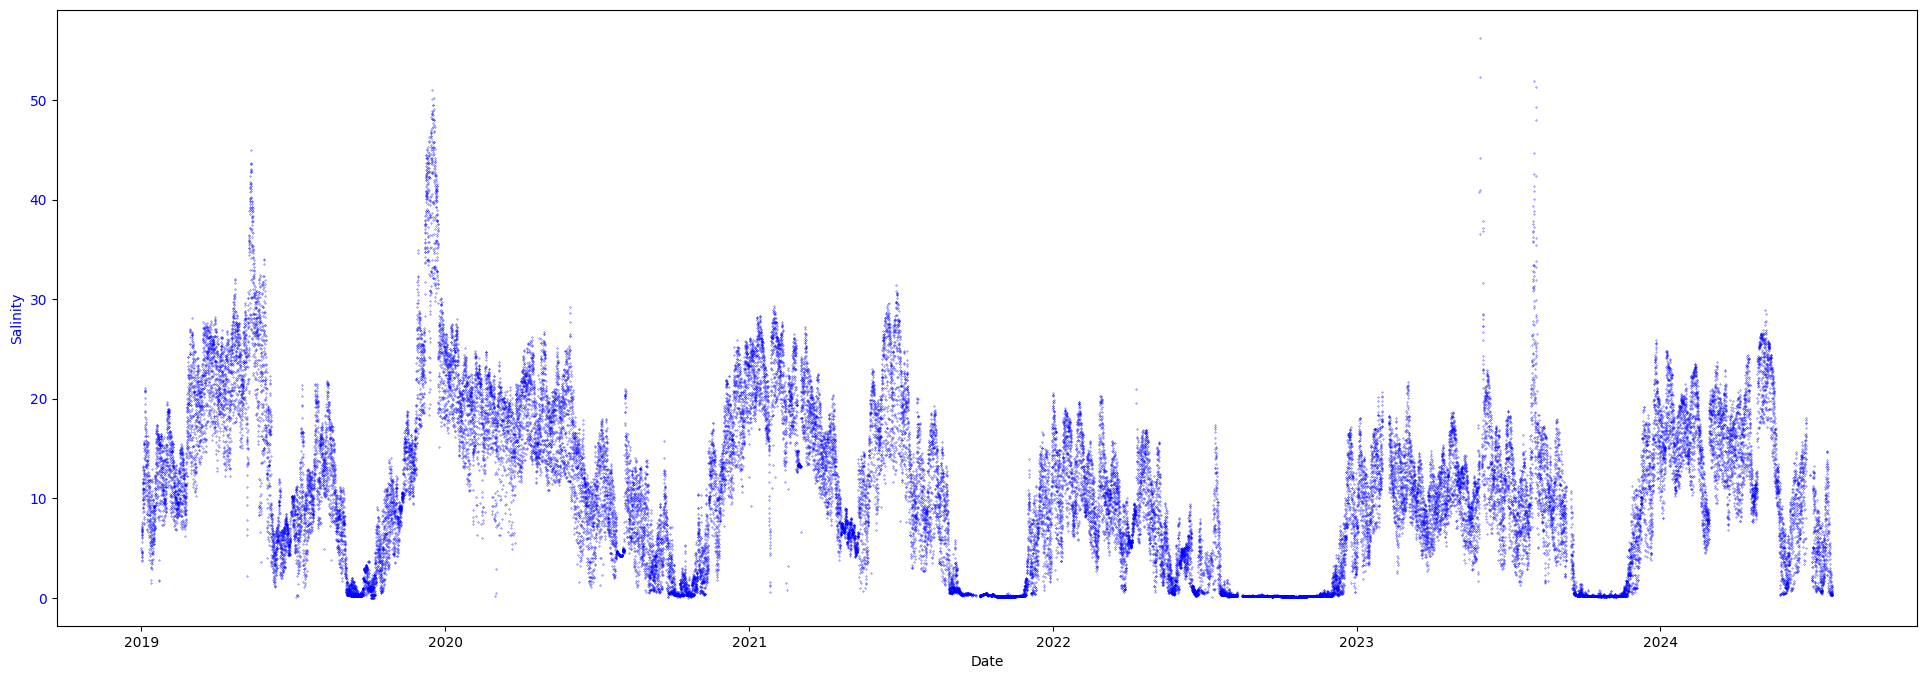

In [201]:
fig2, ax2 = plt.subplots(figsize=(24, 8))
ax2.plot(df.index, df['Salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax2.set_xlabel('Date')
ax2.set_ylabel('Salinity', color='b')
ax2.tick_params(axis='y', labelcolor='b')

In [202]:
# Define column indices dictionary for df
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split data into training, validation, and test sets
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Define number of features based on df1's columns
num_features = df.shape[1]

In [203]:
# Step 1: Log Transformation
train_df.loc[:, 'Salinity'] = np.log1p(train_df['Salinity'])
val_df.loc[:, 'Salinity'] = np.log1p(val_df['Salinity'])
test_df.loc[:, 'Salinity'] = np.log1p(test_df['Salinity'])

In [204]:
# Step 2: Robust Scaling
scaler1 = RobustScaler()
scaler2 = QuantileTransformer()

# Apply RobustScaler using .loc to avoid warnings
train_df.loc[:, 'Salinity'] = scaler1.fit_transform(train_df[['Salinity']])
val_df.loc[:, 'Salinity'] = scaler1.transform(val_df[['Salinity']])
test_df.loc[:, 'Salinity'] = scaler1.transform(test_df[['Salinity']])

train_df.loc[:, 'Salinity'] = scaler2.fit_transform(train_df[['Salinity']])
val_df.loc[:, 'Salinity'] = scaler2.transform(val_df[['Salinity']])
test_df.loc[:, 'Salinity'] = scaler2.transform(test_df[['Salinity']])

In [205]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  @property 
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df, shuffle=False)

  @property
  def test(self):
    return self.make_dataset(self.test_df, shuffle=False)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  
  def make_dataset(self, data, shuffle=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

In [206]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [207]:
window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['Salinity'])

In [208]:
class LSTMConvHyperModel(HyperModel):
    def build(self, hp):
        # Define the exponential decay learning rate schedule with tunable parameters
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=hp.Choice('initial_learning_rate', [1e-2, 1e-3, 1e-4]),  # Tunable: 0.01, 0.001, 0.0001
            decay_steps=hp.Int('decay_steps', min_value=500, max_value=2000, step=500),     # Tunable: 500, 1000, 1500, 2000
            decay_rate=hp.Float('decay_rate', min_value=0.5, max_value=1.0, step=0.05),    # Tunable: 0.8, 0.85, ..., 1.0
            staircase=hp.Boolean('staircase')                                             # Tunable: True or False
        )
        
        # Build the model
        model = tf.keras.models.Sequential(name='LSTMConv_HyperModel')
        
        # Conv1D Layer with tunable filters, kernel size, and activation
        model.add(tf.keras.layers.Conv1D(
            filters=hp.Int('filters', min_value=32, max_value=521, step=32),
            kernel_size=hp.Choice('kernel_size', [1, 2, 3, 5, 6, 7, 8]),
            activation=hp.Choice(
                'activation', 
                ['relu', 'sigmoid', 'tanh', 'linear', 'softplus', 'softsign', 
                 'elu', 'selu', 'exponential']
            ),
            padding='same',
            input_shape=(24, 5)
        ))
        
        # LSTM Layer with tunable units
        model.add(tf.keras.layers.LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=512, step=32),
            return_sequences=True
        ))
        
        # TimeDistributed Dense Layer
        model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
            units=hp.Int('dense_units', min_value=1, max_value=512, step=32)
        )))
        
        # Compile the model with the tunable learning rate schedule
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss='mse',  # Mean Squared Error
            metrics=['mae']  # Mean Absolute Error
        )
        
        return model

In [209]:
# Create an instance of the HyperModel
hypermodel = LSTMConvHyperModel()

# Define the tuner
tuner = RandomSearch(
    hypermodel=hypermodel,
    objective='val_loss',  # Minimize validation loss
    max_trials=20,         # Number of hyperparameter combinations to try
    directory='tuning_dir',
    project_name='tunable_lr_schedule'
)

# Start the tuning process
tuner.search(window.train, validation_data=window.val, epochs=30, batch_size=32)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model with additional epochs if needed
history = best_model.fit(window.train, validation_data=window.val, epochs=30)

Trial 10 Complete [00h 11m 06s]
val_loss: 4.90051788801793e-05

Best val_loss So Far: 3.972250851802528e-05
Total elapsed time: 03h 18m 09s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
0.0001            |0.001             |initial_learning_rate
1000              |1500              |decay_steps
0.9               |0.85              |decay_rate
True              |True              |staircase
512               |448               |filters
8                 |6                 |kernel_size
relu              |softsign          |activation
352               |384               |lstm_units
385               |33                |dense_units

Epoch 1/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step - loss: 0.0579 - mae: 0.1408 - val_loss: 0.0011 - val_mae: 0.0238
Epoch 2/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - loss: 0.0010 - mae: 0.0219 - val_loss: 6.1735e-04 - val_mae: 0.0170
Epoch 3/30
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - loss: 6.3180e-04 - ma

KeyboardInterrupt: 